In [5]:
#1. Descriptive analysis of our  data
#Topic: 
#    Prediction rate of volontary termination of pregnancy
#Goal:
#How do geographical and temporal factors influence the rate of voluntary termination of pregnancy at the departmental level, and how can we predict its future evolution ?

#Benfits:
#Prediction can help regional autority to predict the need in infrastructure and medical staff. 
    
#Sources: 
#    Data.drees.solidarites-sante.gouv.fr
#    Système national des données de santé (SNDS) ; traitements Drees
    
    

#Description of the Dataset: 
#Number of rows: 1 121
#Number of columns : 9


#ZONE_GEO : The geographical area covered by the data, a department such as ‘Ain’ or an aggregation such as ‘France entière’ or ‘région’, from 2016 to 2024. Text (Object)
#IVG_HOSP_INS : Number of abortions (IVG) performed in hospital (full hospitalisation) using surgical instruments. Number (Float)
#IVG_HOSP_MED : Number of abortions performed in hospital (inpatient or outpatient) using medication. Number (Float)
#IVG_HOSP_INC :  Number of abortions performed in hospital for unspecified or unknown reasons.    Number (Float)
#IVG_CAB	: Number of abortions performed in a doctor's office or healthcare facility without full hospitalisation. Number (Float)
#IVG_CEN	: Number of abortions performed in family planning or education centres. Number (Float)
#TOT_IVG	: The total number of voluntary terminations of pregnancy recorded for the corresponding GEO_ZONE and year. Number (Float)
#TAUX_rec : The abortion rate. This is generally the number of abortions per 1,000 women of childbearing age (15 to 49 years old). Number (Float)
#annee : The year in which the abortion data was recorded. Number (Int)


In [7]:
#We are importing the data
import pandas as pd

df = pd.read_csv("donnees_feuil1.csv", delimiter=';', encoding='ISO-8859-1')

print(df.head())
print(df.info())

                  ZONE_GEO  IVG_HOSP_INS  IVG_HOSP_MED  IVG_HOSP_INC  IVG_CAB  \
0                      Ain         375.0         715.0           2.0    591.0   
1                    Aisne         313.0        1193.0           5.0    245.0   
2                   Allier         149.0         409.0           2.0    419.0   
3  Alpes-de-Haute-Provence         110.0         262.0           2.0    158.0   
4             Hautes-Alpes          87.0         114.0           2.0    299.0   

   IVG_CEN  TOT_IVG     TAUX_rec   annee  
0    153.0   1836.0  12,86038497  2024.0  
1     13.0   1769.0  17,22308224  2024.0  
2     13.0    992.0  17,02536642  2024.0  
3     62.0    594.0  20,04251442  2024.0  
4     48.0    550.0  21,82020154  2024.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121 entries, 0 to 1120
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ZONE_GEO      1080 non-null   object 
 1   IVG_HOSP_INS  1

In [9]:
#2. Problèmes de qualité détectés

#TAUX_rec is text with commas to convert to float.

#Some values are missing in all columns.

#We delete each region and total to conserve only departement to avoid biais

In [11]:
#3. Convestion of Taux_rec's separator:
df['TAUX_rec_clean'] = (
    df['TAUX_rec']
    .astype(str)                               
    .str.replace(',', '.', regex=False)       
    .str.replace(r'[^0-9\.]', '', regex=True) 
)


df['TAUX_rec_clean'] = pd.to_numeric(df['TAUX_rec_clean'], errors='coerce')

In [13]:
# 3. Filtrage des lignes agrégées (régions, totaux, etc.)
aggregate_keywords = ["Total", "France entière", "Résidence inconnue", "résidence à l'étranger",
    "Auvergne", "Bourgogne", "Bretagne", "Centre", "Corse", "Grand Est",
    "Guadeloupe", "Guyane", "Hauts-de-France", "Île-de-France", "La Réunion",
    "Martinique", "Mayotte", "Normandie", "Nouvelle-Aquitaine", "Occitanie",
    "Pays de la Loire", "Provence"]

mask = df['ZONE_GEO'].astype(str).str.contains('|'.join(aggregate_keywords), case=False, na=False)
df_filtered =df[mask].copy()

In [15]:
df_cleaned = df_filtered.dropna().copy()

df_cleaned['annee'] = df_cleaned['annee'].astype(int)

print(f"Pré-traitement terminé. Taille du DataFrame nettoyé : {len(df_cleaned)} lignes.")

Pré-traitement terminé. Taille du DataFrame nettoyé : 216 lignes.


In [17]:
#3. Formalisation du problème

#We are going to use linear regression to predict the number of the IVG into a specific region for the next year by using RMSE or MAE
#Also, we are going to classify by calculate accuracy, F1-score and confusion Matrix to classify for example regions by high use of IVG and also classify by method

In [19]:
#We realize that we have too many different values for the ZONE-GEO category, so we will first use only the departments and then only the regions.
df["ZONE_GEO"].nunique()

120

In [21]:
import pandas as pd
import numpy as np

# =============================
# DÉFINITION DE DF_DEPARTEMENTS
# =============================

# Liste complète des 101 départements français (métropole et DOM)
departements = [
    'Ain', 'Aisne', 'Allier', 'Alpes-de-Haute-Provence', 'Hautes-Alpes',
    'Alpes-Maritimes', 'Ardèche', 'Ardennes', 'Ariège', 'Aube',
    'Aude', 'Aveyron', 'Bouches-du-Rhône', 'Calvados', 'Cantal',
    'Charente', 'Charente-Maritime', 'Cher', 'Corrèze', 'Corse-du-Sud',
    'Haute-Corse', 'Côte-d\'Or', 'Côtes-d\'Armor', 'Creuse', 'Dordogne',
    'Doubs', 'Drôme', 'Eure', 'Eure-et-Loir', 'Finistère',
    'Gard', 'Haute-Garonne', 'Gers', 'Gironde', 'Hérault',
    'Ille-et-Vilaine', 'Indre', 'Indre-et-Loire', 'Isère', 'Jura',
    'Landes', 'Loir-et-Cher', 'Loire', 'Haute-Loire', 'Loire-Atlantique',
    'Loiret', 'Lot', 'Lot-et-Garonne', 'Lozère', 'Maine-et-Loire',
    'Manche', 'Marne', 'Haute-Marne', 'Mayenne', 'Meurthe-et-Moselle',
    'Meuse', 'Morbihan', 'Moselle', 'Nièvre', 'Nord',
    'Oise', 'Orne', 'Pas-de-Calais', 'Puy-de-Dôme', 'Pyrénées-Atlantiques',
    'Hautes-Pyrénées', 'Pyrénées-Orientales', 'Bas-Rhin', 'Haut-Rhin', 'Rhône',
    'Haute-Saône', 'Saône-et-Loire', 'Sarthe', 'Savoie', 'Haute-Savoie',
    'Paris', 'Seine-Maritime', 'Seine-et-Marne', 'Yvelines', 'Deux-Sèvres',
    'Somme', 'Tarn', 'Tarn-et-Garonne', 'Var', 'Vaucluse',
    'Vendée', 'Vienne', 'Haute-Vienne', 'Vosges', 'Yonne',
    'Territoire de Belfort', 'Essonne', 'Hauts-de-Seine', 'Seine-Saint-Denis',
    'Val-de-Marne', 'Val-d\'Oise', 'Seine-et-Marne', 'Yvelines', 'Essonne',
    'Hauts-de-Seine', 'Seine-Saint-Denis', 'Val-de-Marne', 'Val-d\'Oise',
    'Guadeloupe',
    'Guyane',
    'Martinique',
    'La Réunion',
    'Mayotte'
]

# 2. Filtrer le DataFrame 'df' pour NE GARDER QUE les départements
df_departements = df[df["ZONE_GEO"].isin(departements)].copy()

# 3. Affichage du nombre de zones uniques pour vérification
print(f"Nombre de départements uniques retenus : {df_departements['ZONE_GEO'].nunique()}")

Nombre de départements uniques retenus : 101


In [23]:
#Calcul du taux d'IVG moyen en utilisant les départements
moyenne_taux_ivg_departements = df_departements['TAUX_rec_clean'].mean()

print(f" Moyenne du taux d'IVG pour les départements : {moyenne_taux_ivg_departements:.4f}")

 Moyenne du taux d'IVG pour les départements : 15.3262


C:\Users\nolwenn\AppData\Local\Temp\ipykernel_17340\2893157260.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10, x='TAUX_rec_clean', y='ZONE_GEO', palette='Reds_d')
C:\Users\nolwenn\AppData\Local\Temp\ipykernel_17340\2893157260.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom_10, x='TAUX_rec_clean', y='ZONE_GEO', palette='Blues_d')


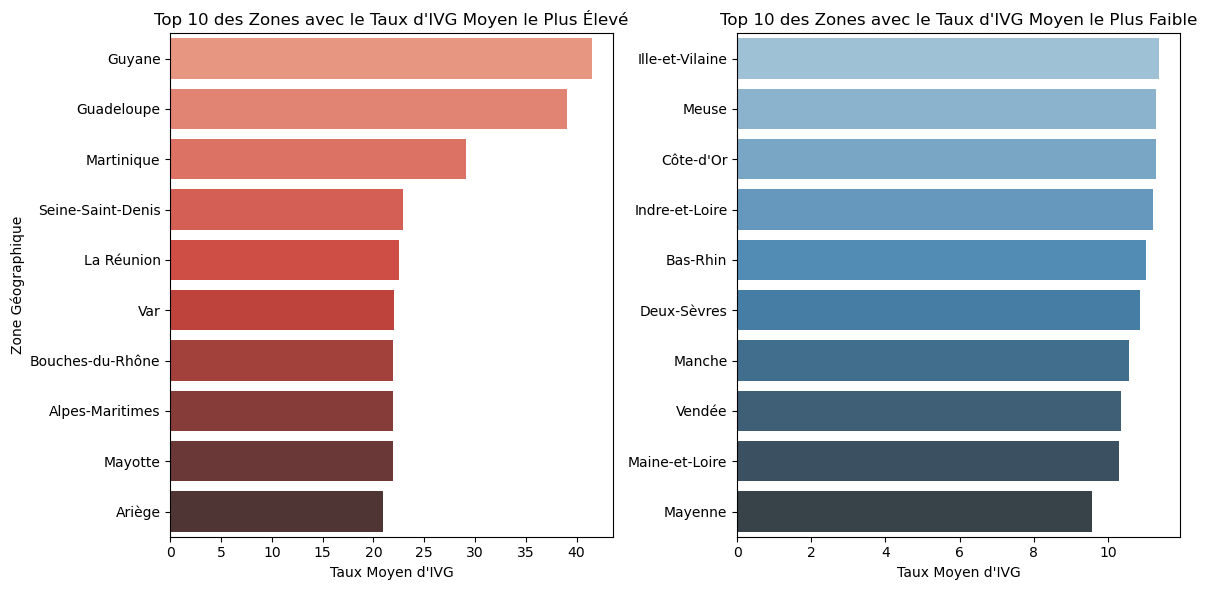

In [25]:
#Geographical Analysis of the Abortion Rate by Department

import matplotlib.pyplot as plt
import seaborn as sns

# Calculation of the average abortion rate by ZONE_GEO across all years
taux_moyen_par_zone = df_departements.groupby('ZONE_GEO')['TAUX_rec_clean'].mean().sort_values(ascending=False).reset_index()

# Top 10 areas with the highest rate
top_10 = taux_moyen_par_zone.head(10)
# Top 10 areas with the lowest rate
bottom_10 = taux_moyen_par_zone.tail(10)

plt.figure(figsize=(12, 6))

# Displaying the TOP 10
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st figure
sns.barplot(data=top_10, x='TAUX_rec_clean', y='ZONE_GEO', palette='Reds_d')
plt.title('Top 10 des Zones avec le Taux d\'IVG Moyen le Plus Élevé', fontsize=12)
plt.xlabel('Taux Moyen d\'IVG')
plt.ylabel('Zone Géographique')

# Displaying the BOTTOM 10
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd figure
sns.barplot(data=bottom_10, x='TAUX_rec_clean', y='ZONE_GEO', palette='Blues_d')
plt.title('Top 10 des Zones avec le Taux d\'IVG Moyen le Plus Faible', fontsize=12)
plt.xlabel('Taux Moyen d\'IVG')
plt.ylabel('') 
plt.tight_layout()
plt.show()

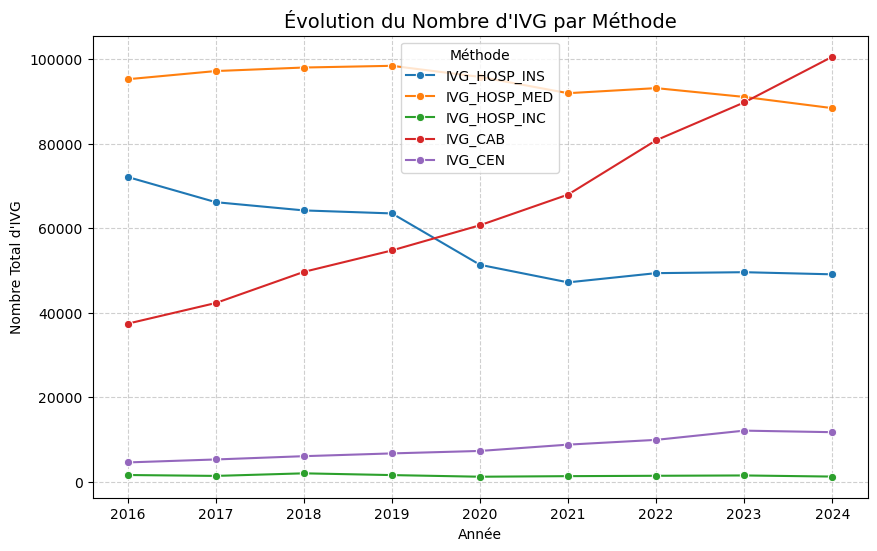

In [26]:
#Analysis of the Distribution of Abortion Methods

# Selection of columns of abortion methods
methodes_cols = ['IVG_HOSP_INS', 'IVG_HOSP_MED', 'IVG_HOSP_INC', 'IVG_CAB', 'IVG_CEN']

# Calculation of the total sum for each method per year
methodes_annuelles = df_departements.groupby('annee')[methodes_cols].sum().reset_index()

# Preparing data for a stacked chart
methodes_melted = methodes_annuelles.melt(
    id_vars='annee',
    value_vars=methodes_cols,
    var_name='Methode_IVG',
    value_name='Nombre_IVG'
)

plt.figure(figsize=(10, 6))
# Create a melted area chart to show the evolution of the proportion
sns.lineplot(
    data=methodes_melted,
    x='annee',
    y='Nombre_IVG',
    hue='Methode_IVG',
    marker='o'
)

plt.title('Évolution du Nombre d\'IVG par Méthode', fontsize=14)
plt.xlabel('Année')
plt.ylabel('Nombre Total d\'IVG')
plt.legend(title='Méthode')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [27]:
#Now we only keep the regional values

regions = [
    "Auvergne -  Rhône-Alpes",
    "Bourgogne -  Franche-Comté",
    "Bretagne",
    "Centre -  Val de Loire",
    "Corse",
    "Grand Est",
    "Hauts-de-France",
    "Ile-de-France",
    "Normandie",
    "Nouvelle-Aquitaine",
    "Occitanie",
    "Pays de la Loire",
    "Provence - Alpes - Côte d'Azur"
]

df_regions = df[df["ZONE_GEO"].isin(regions)].copy()
df_regions["ZONE_GEO"].nunique()


13


Classement des régions par Taux Moyen d'IVG (du plus élevé au plus faible) :
                          ZONE_GEO  TAUX_rec_clean
0   Provence - Alpes - Côte d'Azur       21.606959
1                    Ile-de-France       17.860030
2                            Corse       17.273115
3                        Occitanie       16.854175
4               Nouvelle-Aquitaine       14.149686
5                  Hauts-de-France       13.783525
6          Auvergne -  Rhône-Alpes       13.651088
7           Centre -  Val de Loire       13.595329
8       Bourgogne -  Franche-Comté       12.800469
9                        Normandie       12.623903
10                       Grand Est       12.351502
11                        Bretagne       12.014057
12                Pays de la Loire       11.144015


C:\Users\nolwenn\AppData\Local\Temp\ipykernel_17340\1361540127.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


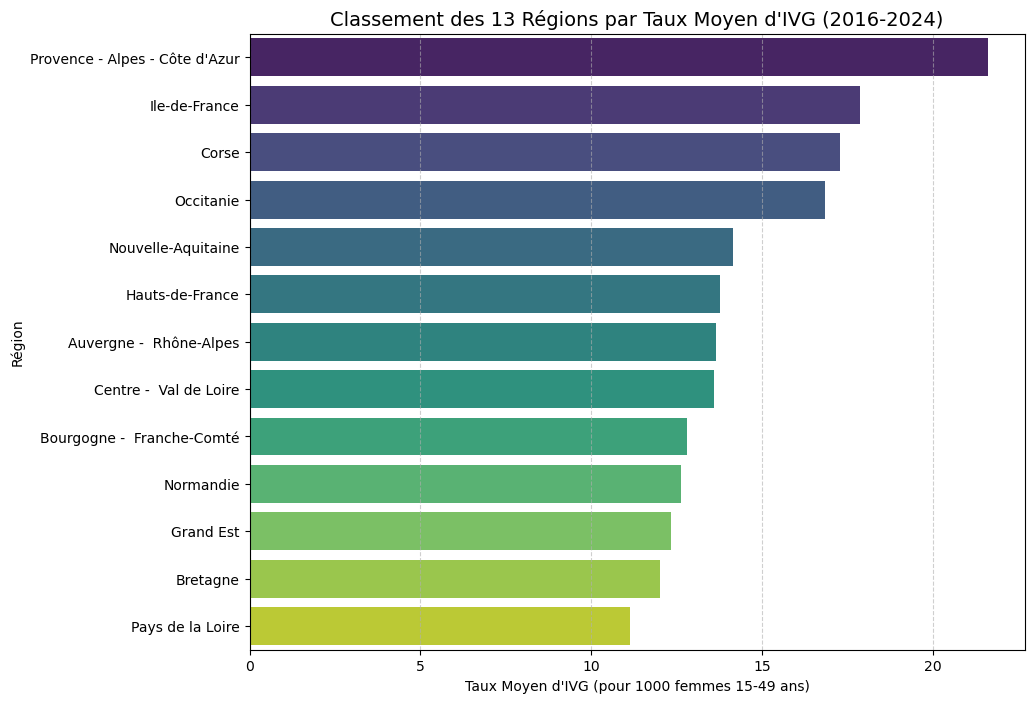

In [28]:
# Calculation of the Average Abortion Rate by Region

# Calculate the average abortion rate for each region across all years
taux_moyen_par_region = df_regions.groupby('ZONE_GEO')['TAUX_rec_clean'].mean().sort_values(ascending=False).reset_index()

# Display the sorted data
print("\nClassement des régions par Taux Moyen d'IVG (du plus élevé au plus faible) :")
print(taux_moyen_par_region)


plt.figure(figsize=(10, 8))

# Use a bar plot to visualize the ranking
sns.barplot(
    data=taux_moyen_par_region,
    x='TAUX_rec_clean',
    y='ZONE_GEO',
    palette='viridis' 
)

plt.title('Classement des 13 Régions par Taux Moyen d\'IVG (2016-2024)', fontsize=14)
plt.xlabel('Taux Moyen d\'IVG (pour 1000 femmes 15-49 ans)')
plt.ylabel('Région')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

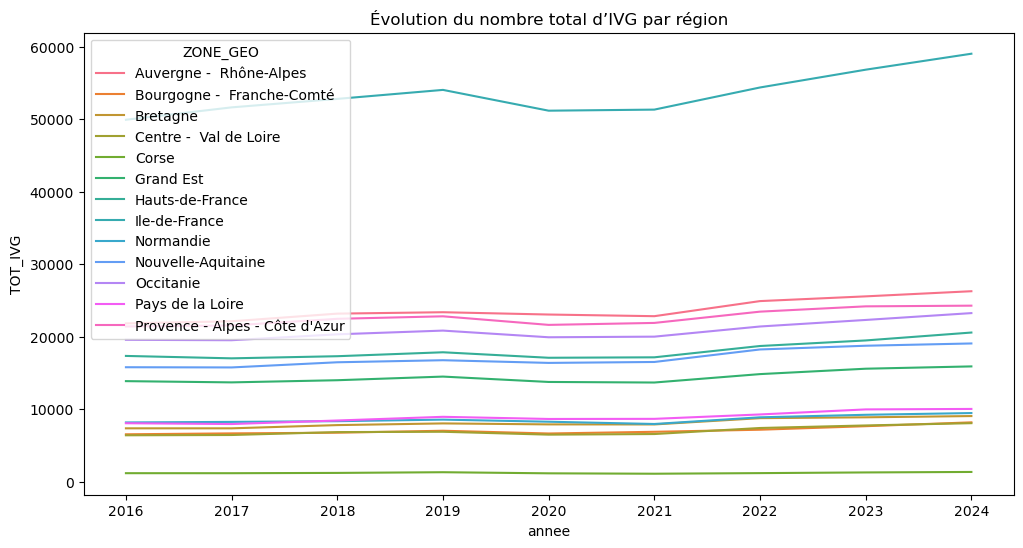

In [32]:
#Calculation of the evolution of the total number of abortions by region

plt.figure(figsize=(12,6))
sns.lineplot(data=df_regions, x="annee", y="TOT_IVG", hue="ZONE_GEO")
plt.title("Évolution du nombre total d’IVG par région")
plt.show()


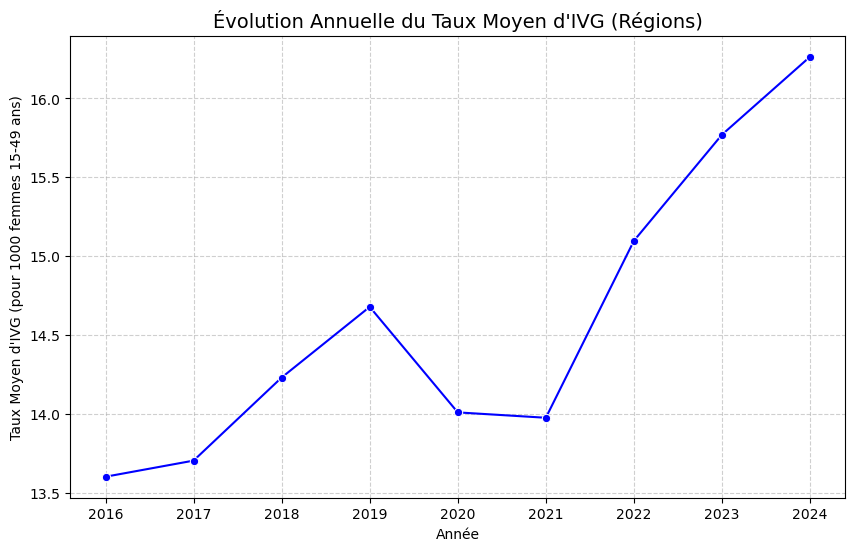

In [34]:
#Average Time Evolution of the Abortion Rate

# Calculate the average abortion rate per year
taux_moyen_par_annee = df_regions.groupby('annee')['TAUX_rec_clean'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=taux_moyen_par_annee, x='annee', y='TAUX_rec_clean', marker='o', color='blue')

plt.title('Évolution Annuelle du Taux Moyen d\'IVG (Régions)', fontsize=14)
plt.xlabel('Année')
plt.ylabel('Taux Moyen d\'IVG (pour 1000 femmes 15-49 ans)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(taux_moyen_par_annee['annee']) 
plt.show()


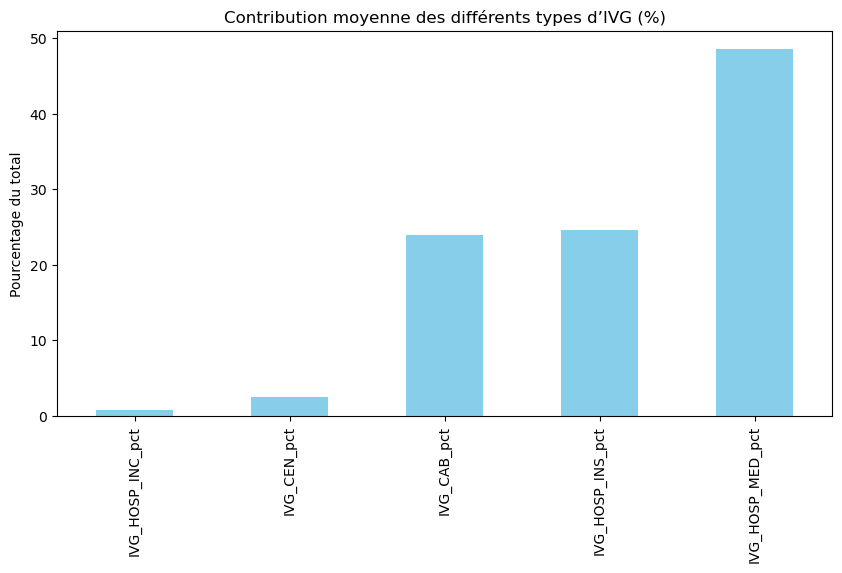

In [37]:
#Contribution of abortion types to the total

df_types = df[["IVG_HOSP_INS","IVG_HOSP_MED","IVG_HOSP_INC","IVG_CAB","IVG_CEN","TOT_IVG"]].copy()

for col in ["IVG_HOSP_INS","IVG_HOSP_MED","IVG_HOSP_INC","IVG_CAB","IVG_CEN"]:
    df_types[col+"_pct"] = df_types[col] / df_types["TOT_IVG"] * 100

contrib_cols = [c for c in df_types.columns if "_pct" in c]

df_contrib_mean = df_types[contrib_cols].mean()

plt.figure(figsize=(10,5))
df_contrib_mean.sort_values().plot(kind="bar", color="skyblue")
plt.title("Contribution moyenne des différents types d’IVG (%)")
plt.ylabel("Pourcentage du total")
plt.show()

In [39]:
#4. Selection of a baseline model and implementation of the model.

#Prediction of IVG rate 
#by department, year and eventually type of IVG
#it's multiple linear regression

#Classification
#Classify a department for a specific year. 
#Decision tree or logistic regression

In [41]:
#baseline Linear regression 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

df_cleaned['TAUX_rec'] = (
    df_cleaned['TAUX_rec']
    .astype(str)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

X = df_cleaned[['ZONE_GEO', 'annee']]
y = df_cleaned['TAUX_rec']


test_year = 2024
X_train = X[X['annee'] < test_year]
X_test = X[X['annee'] == test_year]
y_train = y[X['annee'] < test_year]
y_test = y[X['annee'] == test_year]


X_full = pd.get_dummies(X, columns=['ZONE_GEO'], drop_first=True)
X_train_processed = X_full.loc[X_train.index]
X_test_processed = X_full.loc[X_test.index]


baseline_model = LinearRegression()
baseline_model.fit(X_train_processed, y_train)


y_pred = baseline_model.predict(X_test_processed)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Le RMSE du modèle de référence sur les données de 2024 est : {rmse:.4f}")

Le RMSE du modèle de référence sur les données de 2024 est : 2.0493


In [43]:
#Baseline linear regression commentary: To use a more complex regression model, its result must have an RMSE lower than our reference model #relative error of 13.6% good start

In [45]:
#baseline classification
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


test_year = 2024
df_train = df_cleaned[df_cleaned['annee'] < test_year].copy()
df_test = df_cleaned[df_cleaned['annee'] == test_year].copy()



tertiles = df_train['TAUX_rec'].quantile([0.33, 0.66])
Q1 = tertiles.iloc[0]
Q2 = tertiles.iloc[1]


def categorize_taux(taux):
    if taux <= Q1:
        return 'Faible'
    elif taux <= Q2:
        return 'Moyen'
    else:
        return 'Élevé'


df_cleaned['TAUX_CLASS'] = df_cleaned['TAUX_rec'].apply(categorize_taux)

X = df_cleaned[['ZONE_GEO', 'annee']]
y = df_cleaned['TAUX_CLASS']

X_train = X[df_cleaned['annee'] < test_year]
X_test = X[df_cleaned['annee'] == test_year]
y_train = y[df_cleaned['annee'] < test_year]
y_test = y[df_cleaned['annee'] == test_year]


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['ZONE_GEO']),
        ('num', 'passthrough', ['annee'])
    ],
    remainder='passthrough'
)

# Créer le Pipeline (Pré-traitement + Modèle de Classification)

model_classification = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', multi_class='auto', random_state=42))
])


model_classification.fit(X_train, y_train)
y_pred_class = model_classification.predict(X_test)


accuracy = accuracy_score(y_test, y_pred_class)

print(f"\n--- Résultat du Modèle de Classification Baseline (Régression Logistique) ---")
print(f"Quantiles utilisés pour la classification (Q1: {Q1:.2f}, Q2: {Q2:.2f})")
print(f"Précision (Accuracy) sur l'année 2024 : {accuracy:.4f}")
print("\n--- Rapport de Classification (Détails) ---")
print(classification_report(y_test, y_pred_class))

from sklearn.dummy import DummyClassifier

# --- 1. Création du Modèle de Classification Majoritaire ---

baseline_majoritaire = DummyClassifier(strategy='most_frequent', random_state=42)

# --- 2. Entraînement et Prédiction ---

baseline_majoritaire.fit(X_train, y_train)

# Prédiction sur y_test
y_pred_majoritaire = baseline_majoritaire.predict(X_test)

# --- 3. Évaluation ---
accuracy_majoritaire = accuracy_score(y_test, y_pred_majoritaire)
major_class_index = np.argmax(baseline_majoritaire.class_prior_)
major_class_name = baseline_majoritaire.classes_[major_class_index]


print(f"\n------------------------------------------------------------")
print(f"--- Résultat de la Baseline Majoritaire (Seuil Minimal) ---")
print(f"Classe Majoritaire dans l'entraînement : {major_class_name}")
print(f"Précision (Accuracy) de la Baseline Majoritaire : {accuracy_majoritaire:.4f}")
print(f"------------------------------------------------------------\n")

# Comparaison des résultats
if accuracy > accuracy_majoritaire:
    print(f"Le modèle de Régression Logistique ({accuracy:.4f}) bat la Baseline Majoritaire.")
else:
    print(f"ALERTE : Le modèle Logistique ({accuracy:.4f}) NE bat PAS la Baseline Majoritaire ({accuracy_majoritaire:.4f}). Le modèle n'apporte pas de valeur.")


--- Résultat du Modèle de Classification Baseline (Régression Logistique) ---
Quantiles utilisés pour la classification (Q1: 14.05, Q2: 18.45)
Précision (Accuracy) sur l'année 2024 : 0.6250

--- Rapport de Classification (Détails) ---
              precision    recall  f1-score   support

      Faible       0.33      1.00      0.50         3
       Moyen       0.57      0.40      0.47        10
       Élevé       1.00      0.73      0.84        11

    accuracy                           0.62        24
   macro avg       0.63      0.71      0.60        24
weighted avg       0.74      0.62      0.64        24


------------------------------------------------------------
--- Résultat de la Baseline Majoritaire (Seuil Minimal) ---
Classe Majoritaire dans l'entraînement : Élevé
Précision (Accuracy) de la Baseline Majoritaire : 0.4583
------------------------------------------------------------

Le modèle de Régression Logistique (0.6250) bat la Baseline Majoritaire.


In [47]:
## Classification Baseline Summary

#This analysis established the Logistic Regression model as the algorithmic benchmark for predicting the activity rate classes.

#Key Result:The Logistic Regression model achieved an overall accuracy of 62.5% on the 2024 test year, significantly outperforming the Majority Baseline 45.8% – the 'Elevé' class. This validates the utility of the input features.

#Performance by Class:
#    * The model is highly reliable in identifying the `Élevé`(High) class (Precision 1.00), effectively minimizing false alarms for critical cases.
#    * It shows difficulty distinguishing between the `Faible`(Low) and `Moyen`(Medium) rate classes, indicating a lack of linear separability in this range.

#Conclusion:Logistic Regression provides a solid foundation for high-rate detection, but more complex non-linear models(e.g., Random Forest or XGBoost) must be explored to refine the classification fidelity across the low and medium rate categories.

In [49]:
#The main objective of executing this code is to answer the question: Does adding the non-linearity and interaction capability of the Decision Tree reduce classification errors, particularly between the ‘Low’ and ‘Medium’ classes, compared to Logistic Regression?

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd


test_year = 2024
df_cleaned['TAUX_CLASS'] = df_cleaned['TAUX_rec'].apply(categorize_taux) # Réapplique la classification
X = df_cleaned[['ZONE_GEO', 'annee']]
y = df_cleaned['TAUX_CLASS']

X_train = X[df_cleaned['annee'] < test_year]
X_test = X[df_cleaned['annee'] == test_year]
y_train = y[df_cleaned['annee'] < test_year]
y_test = y[df_cleaned['annee'] == test_year]

# Définition du pré-processeur (identique au modèle de régression logistique)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['ZONE_GEO']),
        ('num', 'passthrough', ['annee'])
    ],
    remainder='passthrough'
)

# Création du Pipeline avec le Decision Tree Classifier
model_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42)) # Arbre de Décision
])

# Entraînement et Prédiction
model_tree.fit(X_train, y_train)
y_pred_tree = model_tree.predict(X_test)

# Évaluation
accuracy_tree = accuracy_score(y_test, y_pred_tree)

print(f"\n--- Résultat du Modèle de Classification (Arbre de Décision) ---\n")
print(f"Précision (Accuracy) sur l'année 2024 : {accuracy_tree:.4f}\n")
print("--- Rapport de Classification (Détails) ---\n")
print(classification_report(y_test, y_pred_tree))


--- Résultat du Modèle de Classification (Arbre de Décision) ---

Précision (Accuracy) sur l'année 2024 : 0.8333

--- Rapport de Classification (Détails) ---

              precision    recall  f1-score   support

      Faible       0.75      1.00      0.86         3
       Moyen       0.75      0.90      0.82        10
       Élevé       1.00      0.73      0.84        11

    accuracy                           0.83        24
   macro avg       0.83      0.88      0.84        24
weighted avg       0.86      0.83      0.83        24



In [53]:
#Conclusion: The performance jump is significant. The Decision Tree, a non-linear model, is much better suited to capture the complex relationships between ZONE_GEO and year and to predict the rate class. The model is now performing well.

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np


def categorize_taux(taux):
  
    if taux <= Q1:
        return 'Faible'
    elif taux <= Q2:
        return 'Moyen'
    else:
        return 'Élevé'

df_cleaned['TAUX_CLASS'] = df_cleaned['TAUX_rec'].apply(categorize_taux)

test_year = 2024
X = df_cleaned[['ZONE_GEO', 'annee']]
y = df_cleaned['TAUX_CLASS']

X_train = X[df_cleaned['annee'] < test_year]
X_test = X[df_cleaned['annee'] == test_year]
y_train = y[df_cleaned['annee'] < test_year]
y_test = y[df_cleaned['annee'] == test_year]


# --- 2. Définition du Pré-processeur (Identique) ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['ZONE_GEO']),
        ('num', 'passthrough', ['annee'])
    ],
    remainder='passthrough'
)

# --- 3. Création du Pipeline avec le Random Forest Classifier ---

model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


# --- 4. Entraînement et Prédiction ---
print("Début de l'entraînement du Random Forest...")
model_rf.fit(X_train, y_train)

print("Prédictions sur l'année 2024...")
y_pred_rf = model_rf.predict(X_test)


# --- 5. Évaluation ---
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"\n--- Résultat du Modèle de Classification (Random Forest) ---")
print(f"Précision (Accuracy) sur l'année 2024 : {accuracy_rf:.4f}")
print("\n--- Rapport de Classification (Détails) ---")
print(classification_report(y_test, y_pred_rf))

Début de l'entraînement du Random Forest...
Prédictions sur l'année 2024...

--- Résultat du Modèle de Classification (Random Forest) ---
Précision (Accuracy) sur l'année 2024 : 0.8333

--- Rapport de Classification (Détails) ---
              precision    recall  f1-score   support

      Faible       0.75      1.00      0.86         3
       Moyen       0.75      0.90      0.82        10
       Élevé       1.00      0.73      0.84        11

    accuracy                           0.83        24
   macro avg       0.83      0.88      0.84        24
weighted avg       0.86      0.83      0.83        24



In [57]:
#REGRESSION

In [59]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd

# (Récupération des DataFrames : X et y = TAUX_rec)

test_year = 2024
X = df_cleaned[['ZONE_GEO', 'annee']]
y = df_cleaned['TAUX_rec']

X_train = X[df_cleaned['annee'] < test_year]
X_test = X[df_cleaned['annee'] == test_year]
y_train = y[df_cleaned['annee'] < test_year]
y_test = y[df_cleaned['annee'] == test_year]

# Définition du pré-processeur
preprocessor_reg = ColumnTransformer(
    transformers=[
        # Standardisation pour les variables numériques (annee)
        ('num', StandardScaler(), ['annee']),
        # One-Hot Encoding pour la variable catégorielle (ZONE_GEO)
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['ZONE_GEO'])
    ],
    remainder='passthrough'
)

# Création du Pipeline avec la Régression Ridge
model_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor_reg),
    ('regressor', Ridge(alpha=1.0, random_state=42)) # Régression Ridge
])

# Entraînement et Prédiction
model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test)

# Évaluation
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print(f"\n--- Résultat du Modèle de Régression (Ridge) ---\n")
print(f"RMSE du modèle RIDGE sur l'année 2024 : {rmse_ridge:.4f}")


--- Résultat du Modèle de Régression (Ridge) ---

RMSE du modèle RIDGE sur l'année 2024 : 2.6196


In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import pandas as pd


# --- 2. DÉFINITION DES JEUX D'ENTRÉE/SORTIE ET SÉPARATION TEMPORELLE ---
test_year = 2024

X = df_cleaned[['ZONE_GEO', 'annee']]
y = df_cleaned['TAUX_rec']

# Séparation des données : Entraînement avant 2024, Test sur 2024
X_train = X[df_cleaned['annee'] < test_year].reset_index(drop=True)
X_test = X[df_cleaned['annee'] == test_year].reset_index(drop=True)
y_train = y[df_cleaned['annee'] < test_year].reset_index(drop=True)
y_test = y[df_cleaned['annee'] == test_year].reset_index(drop=True)


# --- 3. PRÉ-PROCESSEUR ET PIPELINE ---

# Définition du pré-processeur
preprocessor_reg = ColumnTransformer(
    transformers=[
        
        ('num', StandardScaler(), ['annee']),
        # OnedHotEncoder pour la variable catégorielle ZONE_GEO
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['ZONE_GEO'])
    ],
    remainder='passthrough'
)

# Création du Pipeline avec le Random Forest Regressor
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_reg),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])


# --- 4. ENTRAÎNEMENT ET ÉVALUATION ---

model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

# Évaluation du RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Affichage du résultat
baseline_rmse_linear = 2.0493 # résultat de la Régression Linéaire
gain = baseline_rmse_linear - rmse_rf

print(f"\n--- Résultat du Modèle de Régression (Random Forest) ---\n")
print(f"RMSE de la Régression Linéaire (Baseline) : {baseline_rmse_linear:.4f}")
print(f"RMSE du modèle RANDOM FOREST sur l'année 2024 : {rmse_rf:.4f}")

if gain > 0:
    print(f"\n Gain obtenu par rapport à la baseline : {gain:.4f}. Le Random Forest a amélioré la performance.")
else:
    print(f"\n Le Random Forest n'a pas réussi à battre la Régression Linéaire. Il est temps de passer au Gradient Boosting.")


--- Résultat du Modèle de Régression (Random Forest) ---

RMSE de la Régression Linéaire (Baseline) : 2.0493
RMSE du modèle RANDOM FOREST sur l'année 2024 : 1.4787

 Gain obtenu par rapport à la baseline : 0.5706. Le Random Forest a amélioré la performance.


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


X = df_cleaned[['ZONE_GEO', 'annee']]
y = df_cleaned['TAUX_rec']

# --- Split temporel ---
test_year = 2024
X_train = X[X['annee'] < test_year]
X_test  = X[X['annee'] == test_year]
y_train = y[X['annee'] < test_year]
y_test  = y[X['annee'] == test_year]

# --- One-hot encoding ---
X_full = pd.get_dummies(X, columns=['ZONE_GEO'], drop_first=True)
X_train_processed = X_full.loc[X_train.index]
X_test_processed  = X_full.loc[X_test.index]

# --- Modèle LASSO ---
lasso_model = Lasso(alpha=0.1)  
lasso_model.fit(X_train_processed, y_train)

# --- Prédiction + RMSE ---
y_pred_lasso = lasso_model.predict(X_test_processed)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print(f"RMSE du modèle LASSO sur 2024 : {rmse_lasso:.4f}")

RMSE du modèle LASSO sur 2024 : 3.2416


In [65]:
#Summary Regression model: 
#We tested various linear models (Ridge and Lasso) and one non-linear model to obtain a better rmse score:  
#    Ridge:2.6196
#    Lasso: 3.2416
#    Random forest: 1.4787
#Exploring non-linear models yielded a significant performance improvement. 
#The Random Forest Regressor achieved the best result with an RMSE of 1.4787, substantially outperforming the linear baseline (RMSE 2.05). 
#Conversely, Ridge and Lasso regularization techniques degraded performance, suggesting that these simpler linear methods were insufficient to capture the complexity of the relationships between the geographical zone and the year.

In [67]:
Partie Loane

SyntaxError: invalid syntax (1323693687.py, line 1)

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

# --- 1. génération des classes selon Q1, Q2 ---
Q1 = df_cleaned['TAUX_rec'].quantile(0.33)
Q2 = df_cleaned['TAUX_rec'].quantile(0.66)

def categorize_taux(taux):
    if taux <= Q1:
        return 'Faible'
    elif taux <= Q2:
        return 'Moyen'
    else:
        return 'Élevé'

df_cleaned['TAUX_CLASS'] = df_cleaned['TAUX_rec'].apply(categorize_taux)

# --- 2. Séparation train / test avec test = 2024 ---
test_year = 2024
X = df_cleaned[['ZONE_GEO', 'annee']]
y = df_cleaned['TAUX_CLASS']

X_train = X[df_cleaned['annee'] < test_year]
X_test = X[df_cleaned['annee'] == test_year]
y_train = y[df_cleaned['annee'] < test_year]
y_test = y[df_cleaned['annee'] == test_year]

# --- 3. Préprocessing ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['ZONE_GEO']),
        ('num', 'passthrough', ['annee'])
    ]
)

# --- 4. Modèle RF Classifier ---
model_rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=300, random_state=42))
])

# --- 5. Entraînement ---
model_rf_clf.fit(X_train, y_train)

# --- 6. Prédiction ---
y_pred_clf = model_rf_clf.predict(X_test)

# --- 7. Évaluation ---
print("\n--- Random Forest Classification ---")
print(f"Accuracy : {accuracy_score(y_test, y_pred_clf):.4f}")
print("\nRapport :")
print(classification_report(y_test, y_pred_clf))



--- Random Forest Classification ---
Accuracy : 0.8750

Rapport :
              precision    recall  f1-score   support

      Faible       0.80      1.00      0.89         4
       Moyen       0.82      0.90      0.86        10
       Élevé       1.00      0.80      0.89        10

    accuracy                           0.88        24
   macro avg       0.87      0.90      0.88        24
weighted avg       0.89      0.88      0.88        24



In [70]:
# ============================================
# 1 — IMPORTS
# ============================================

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

# IMPORTANT : Assurez-vous que votre DataFrame 'df_departements' est défini
# et ne contient AUCUN agrégat (régions, France entière, etc.).

# ============================================
# 2 — NETTOYAGE + CONVERSION TAUX
# (Appliqué à df_departements)
# ============================================

# Création d'une copie pour éviter les SettingWithCopyWarning et travailler sur un DataFrame propre
# On utilise df_departements comme source
df_dep_processed = df_departements.copy()

# Conversion de la colonne 'TAUX_rec' en numérique (float)
df_dep_processed['TAUX_rec'] = (
    df_dep_processed['TAUX_rec']
    .astype(str)
    .str.replace(',', '.', regex=False)  # virgule → point
)

# Correction : Utilisez 'coerce' pour mettre en NaN les valeurs non convertibles, puis les supprimer
df_dep_processed['TAUX_rec'] = pd.to_numeric(df_dep_processed['TAUX_rec'], errors='coerce')
# Supprimer les lignes où la conversion a échoué (NaN)
df_dep_processed.dropna(subset=['TAUX_rec'], inplace=True)


# ============================================
# 3 — CALCUL QUANTILES + CRÉATION DES CLASSES
# (Basé sur les données départementales)
# ============================================

# Calcul des quantiles spécifiques aux départements
Q1_dep = df_dep_processed['TAUX_rec'].quantile(0.33)
Q2_dep = df_dep_processed['TAUX_rec'].quantile(0.66)

def categorize_taux_dep(taux):
    if taux <= Q1_dep:
        return 'Faible'
    elif taux <= Q2_dep:
        return 'Moyen'
    else:
        return 'Élevé'

df_dep_processed['TAUX_CLASS'] = df_dep_processed['TAUX_rec'].apply(categorize_taux_dep)


# ============================================
# 4 — SÉPARATION TRAIN / TEST (2024 = TEST)
# (Séparation des données départementales)
# ============================================

test_year = 2024

X_dep = df_dep_processed[['ZONE_GEO', 'annee']]
y_class_dep = df_dep_processed['TAUX_CLASS']
y_reg_dep = df_dep_processed['TAUX_rec']

# Séparation des jeux de données d'entraînement et de test
X_train_dep = X_dep[X_dep['annee'] < test_year]
X_test_dep = X_dep[X_dep['annee'] == test_year]

y_train_class_dep = y_class_dep[X_dep['annee'] < test_year]
y_test_class_dep  = y_class_dep[X_dep['annee'] == test_year]

y_train_reg_dep = y_reg_dep[X_dep['annee'] < test_year]
y_test_reg_dep  = y_reg_dep[X_dep['annee'] == test_year]


# ============================================
# 5 — PRÉ-PROCESSEUR COMMUN
# ============================================

preprocessor_dep = ColumnTransformer(
    transformers=[
        # Le OneHotEncoder transforme chaque département en une colonne binaire
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['ZONE_GEO']),
        ('num', 'passthrough', ['annee'])
    ],
    remainder='drop'
)


# ============================================
# 6 — MODÈLE RANDOM FOREST : CLASSIFICATION
# ============================================

model_rf_class_dep = Pipeline(steps=[
    ('preprocess', preprocessor_dep),
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42
    ))
])

print("\nEntraînement modèle de classification des départements…")
model_rf_class_dep.fit(X_train_dep, y_train_class_dep)

y_pred_class_dep = model_rf_class_dep.predict(X_test_dep)
accuracy_dep = accuracy_score(y_test_class_dep, y_pred_class_dep)
print(f"Accuracy (Classification) pour 2024 : {accuracy_dep:.4f}")
# print("\nRapport de classification:\n", classification_report(y_test_class_dep, y_pred_class_dep))


# ============================================
# 7 — MODÈLE RANDOM FOREST : RÉGRESSION
# ============================================

model_rf_reg_dep = Pipeline(steps=[
    ('preprocess', preprocessor_dep),
    ('regressor', RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        random_state=42
    ))
])

print("\nEntraînement modèle de régression des départements…")
model_rf_reg_dep.fit(X_train_dep, y_train_reg_dep)

y_pred_reg_dep = model_rf_reg_dep.predict(X_test_dep)
rmse_dep = np.sqrt(mean_squared_error(y_test_reg_dep, y_pred_reg_dep))

print(f"RMSE (Régression) pour 2024 : {rmse_dep:.4f}")


# ============================================
# 8 — PRÉDICTIONS POUR L'ANNÉE 2025 (DÉPARTEMENTS SEULEMENT)
# ============================================

# Utilisation des zones géographiques uniques PRÉSENTES dans df_departements,
# qui sont donc uniquement des départements.
zones_dep_pred = df_dep_processed['ZONE_GEO'].unique()

df_2025_dep = pd.DataFrame({
    'ZONE_GEO': zones_dep_pred,
    'annee': [2025] * len(zones_dep_pred)
})

# Prédictions
pred_2025_reg_dep = model_rf_reg_dep.predict(df_2025_dep)
pred_2025_class_dep = model_rf_class_dep.predict(df_2025_dep)

df_predictions_2025_dep = df_2025_dep.copy()
df_predictions_2025_dep['TAUX_PRED_2025'] = pred_2025_reg_dep
df_predictions_2025_dep['CLASS_PRED_2025'] = pred_2025_class_dep

print("\n========== PRÉDICTIONS POUR L'ANNÉE 2025 (DÉPARTEMENTS) ==========")
# Affichage des prédictions pour 2025 pour chaque département
print(df_predictions_2025_dep.to_string(index=False))


Entraînement modèle de classification des départements…
Accuracy (Classification) pour 2024 : 0.8119

Entraînement modèle de régression des départements…
RMSE (Régression) pour 2024 : 1.3395

========== PRÉDICTIONS POUR L'ANNÉE 2025 (DÉPARTEMENTS) ==========
               ZONE_GEO  annee  TAUX_PRED_2025 CLASS_PRED_2025
                    Ain   2025       13.478556           Moyen
                  Aisne   2025       16.109563           Élevé
                 Allier   2025       16.007513           Élevé
Alpes-de-Haute-Provence   2025       20.469819           Élevé
           Hautes-Alpes   2025       19.463723           Élevé
        Alpes-Maritimes   2025       22.644728           Élevé
                Ardèche   2025       16.115937           Élevé
               Ardennes   2025       14.537097           Moyen
                 Ariège   2025       19.119673           Élevé
                   Aube   2025       15.782647           Élevé
                   Aude   2025       19.890658 

In [81]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# ------------------------------------------------------------------
# 0) Chargement et préparation des données
# ------------------------------------------------------------------


method_cols = [
    'IVG_HOSP_INS', 'IVG_HOSP_MED', 'IVG_HOSP_INC', 'IVG_CAB', 'IVG_CEN'
]

# Conversion et nettoyage
for col in method_cols:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

df_cleaned['TAUX_rec'] = (
    df_cleaned['TAUX_rec'].astype(str).str.replace(',', '.', regex=False)
)
df_cleaned['TAUX_rec'] = pd.to_numeric(df_cleaned['TAUX_rec'], errors='coerce')
df_cleaned['TOT_IVG'] = pd.to_numeric(df_cleaned['TOT_IVG'], errors='coerce')

# Filtrage des lignes agrégées
aggregate_keywords = [
    'France entière', 'Total IVG', 'Résidence inconnue', 'résidence à l\'étranger'
]
df_cleaned = df_cleaned[~df_cleaned['ZONE_GEO'].str.contains('|'.join(aggregate_keywords), case=False, na=False)].copy()

# Création des variables de proportion pour la régression multi-output
prop_cols = ['PROP_INS', 'PROP_MED', 'PROP_INC', 'PROP_CAB', 'PROP_CEN']

for method, prop in zip(method_cols, prop_cols):
    df_cleaned[prop] = df_cleaned[method].fillna(0) / df_cleaned['TOT_IVG']
    df_cleaned[prop] = df_cleaned[prop].fillna(0)


# ------------------------------------------------------------------
# 1) Train/Test split et Préprocesseur
# ------------------------------------------------------------------

test_year = 2024
X = df_cleaned[['ZONE_GEO', 'annee']]
y_reg = df_cleaned['TAUX_rec']
y_multi_reg = df_cleaned[prop_cols] 

mask_train = df_cleaned['annee'] < test_year
mask_test = df_cleaned['annee'] == test_year 

X_train = X[mask_train]
X_test = X[mask_test]
y_test_reg = y_reg[mask_test]

# Préprocesseur : One-Hot Encoding pour ZONE_GEO
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['ZONE_GEO']),
        ('num', 'passthrough', ['annee'])
    ]
)


# ------------------------------------------------------------------
# 2) Modèles et Entraînement
# ------------------------------------------------------------------

# Modèle 1: Régression simple (TAUX_rec)
model_rf_reg = Pipeline(steps=[
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=300, random_state=42))
])
model_rf_reg.fit(X_train, y_reg[mask_train])

# Modèle 2: Régression Multi-Output (Proportions)
model_rf_multi = Pipeline(steps=[
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=300, random_state=42))
])
model_rf_multi.fit(X_train, y_multi_reg[mask_train])


# ------------------------------------------------------------------
# 3) Évaluation et Résultats du Modèle de Taux (RMSE)
# ------------------------------------------------------------------

pred_reg_2024 = model_rf_reg.predict(X_test)
mse = mean_squared_error(y_test_reg, pred_reg_2024)
rmse = np.sqrt(mse)

print("--- ÉVALUATION MODELE REGRESSION (TAUX_rec) ---")
print(f"RMSE (Erreur quadratique moyenne) : {rmse:.4f}")

# ------------------------------------------------------------------
# 4) Prédictions 2025 et Q1 : Top 3 Taux
# ------------------------------------------------------------------

zones = df_cleaned['ZONE_GEO'].unique()
df_2025 = pd.DataFrame({
    'ZONE_GEO': zones,
    'annee': [2025] * len(zones)
})

# Prédiction du Taux
df_2025['PRED_TAUX_2025'] = model_rf_reg.predict(df_2025)

# Affichage du Top 3
df_top3 = df_2025.sort_values(by='PRED_TAUX_2025', ascending=False).head(3)

print("\n=== QUESTION 1 : TOP 3 TAUX d'IVG PRÉDIT (2025) ===")
print(df_top3[['ZONE_GEO', 'PRED_TAUX_2025']].to_markdown(index=False, floatfmt=".4f"))

# ------------------------------------------------------------------
# 5) Q2 : Synthèse pour le Finistère
# ------------------------------------------------------------------

nom_dep = "Finistère"
input_dep = pd.DataFrame({"ZONE_GEO": [nom_dep], "annee": [2025]})

# Taux
pred_taux_finistere = model_rf_reg.predict(input_dep)[0]

# Proportions
pred_proportions_finistere = model_rf_multi.predict(input_dep)[0]

df_proportions = pd.DataFrame({
    'méthode': method_cols, 
    'proportion': pred_proportions_finistere
})

df_proportions['Pourcentage'] = (df_proportions['proportion'] * 100).round(2)
df_proportions_sorted = df_proportions.sort_values(by='Pourcentage', ascending=False)
proba_med_pourcentage = df_proportions_sorted.loc[df_proportions_sorted['méthode'] == 'IVG_HOSP_MED', 'Pourcentage'].values[0]


print(f"\n=== QUESTION 2 : SYNTHÈSE {nom_dep} (2025) ===")
print(f"**Taux d'IVG prédit** : **{pred_taux_finistere:.4f}**")
print("\n**Prédiction des proportions (en pourcentage)** :\n")
print(df_proportions_sorted[['méthode', 'Pourcentage']].to_markdown(index=False))
print(f"\nLe pourcentage d’IVG médicamenteuse (IVG_HOSP_MED) est de **{proba_med_pourcentage:.2f}%**.")

--- ÉVALUATION MODELE REGRESSION (TAUX_rec) ---
RMSE (Erreur quadratique moyenne) : 1.5353

=== QUESTION 1 : TOP 3 TAUX d'IVG PRÉDIT (2025) ===
| ZONE_GEO   |   PRED_TAUX_2025 |
|:-----------|-----------------:|
| Guyane     |          48.8792 |
| Guadeloupe |          44.0421 |
| Martinique |          31.6285 |

=== QUESTION 2 : SYNTHÈSE Finistère (2025) ===
**Taux d'IVG prédit** : **14.4437**

**Prédiction des proportions (en pourcentage)** :

| méthode      |   Pourcentage |
|:-------------|--------------:|
| IVG_HOSP_MED |         37.85 |
| IVG_CAB      |         36.73 |
| IVG_HOSP_INS |         20.77 |
| IVG_CEN      |          4.08 |
| IVG_HOSP_INC |          0.58 |

Le pourcentage d’IVG médicamenteuse (IVG_HOSP_MED) est de **37.85%**.


In [85]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# Colonnes des méthodes d'IVG
method_cols = [
    'IVG_HOSP_INS', 'IVG_HOSP_MED', 'IVG_HOSP_INC', 'IVG_CAB', 'IVG_CEN'
]

# --- 0) Nettoyage et Préparation des données ---

# Conversion des colonnes numériques
for col in method_cols:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

# Conversion du TAUX_rec (gestion de la virgule comme séparateur décimal)
df_cleaned['TAUX_rec'] = (
    df_cleaned['TAUX_rec'].astype(str).str.replace(',', '.', regex=False)
)
df_cleaned['TAUX_rec'] = pd.to_numeric(df_cleaned['TAUX_rec'], errors='coerce')
df_cleaned['TOT_IVG'] = pd.to_numeric(df_cleaned['TOT_IVG'], errors='coerce')
df_cleaned['annee'] = pd.to_numeric(df_cleaned['annee'], errors='coerce')


# DÉFINITION DE DF_DEPARTEMENTS PAR INCLUSION


# Liste complète des 101 départements français (métropole et DOM)
departements = [
    'Ain', 'Aisne', 'Allier', 'Alpes-de-Haute-Provence', 'Hautes-Alpes',
    'Alpes-Maritimes', 'Ardèche', 'Ardennes', 'Ariège', 'Aube',
    'Aude', 'Aveyron', 'Bouches-du-Rhône', 'Calvados', 'Cantal',
    'Charente', 'Charente-Maritime', 'Cher', 'Corrèze', 'Corse-du-Sud',
    'Haute-Corse', 'Côte-d\'Or', 'Côtes-d\'Armor', 'Creuse', 'Dordogne',
    'Doubs', 'Drôme', 'Eure', 'Eure-et-Loir', 'Finistère',
    'Gard', 'Haute-Garonne', 'Gers', 'Gironde', 'Hérault',
    'Ille-et-Vilaine', 'Indre', 'Indre-et-Loire', 'Isère', 'Jura',
    'Landes', 'Loir-et-Cher', 'Loire', 'Haute-Loire', 'Loire-Atlantique',
    'Loiret', 'Lot', 'Lot-et-Garonne', 'Lozère', 'Maine-et-Loire',
    'Manche', 'Marne', 'Haute-Marne', 'Mayenne', 'Meurthe-et-Moselle',
    'Meuse', 'Morbihan', 'Moselle', 'Nièvre', 'Nord',
    'Oise', 'Orne', 'Pas-de-Calais', 'Puy-de-Dôme', 'Pyrénées-Atlantiques',
    'Hautes-Pyrénées', 'Pyrénées-Orientales', 'Bas-Rhin', 'Haut-Rhin', 'Rhône',
    'Haute-Saône', 'Saône-et-Loire', 'Sarthe', 'Savoie', 'Haute-Savoie',
    'Paris', 'Seine-Maritime', 'Seine-et-Marne', 'Yvelines', 'Deux-Sèvres',
    'Somme', 'Tarn', 'Tarn-et-Garonne', 'Var', 'Vaucluse',
    'Vendée', 'Vienne', 'Haute-Vienne', 'Vosges', 'Yonne',
    'Territoire de Belfort', 'Essonne', 'Hauts-de-Seine', 'Seine-Saint-Denis',
    'Val-de-Marne', 'Val-d\'Oise', 'Seine-et-Marne', 'Yvelines', 'Essonne',
    'Hauts-de-Seine', 'Seine-Saint-Denis', 'Val-de-Marne', 'Val-d\'Oise',
    
    # Départements d'Outre-Mer (DOM)
    'Guadeloupe',
    'Guyane',
    'Martinique',
    'La Réunion',
    'Mayotte'
]

# 2. Filtrer le DataFrame 'df' pour NE GARDER QUE les départements
df_departements = df[df["ZONE_GEO"].isin(departements)].copy()

# 3. Affichage du nombre de zones uniques pour vérification
print(f"Nombre de départements uniques retenus : {df_departements['ZONE_GEO'].nunique()}")



# Création des variables de proportion pour la régression multi-output
prop_cols = ['PROP_INS', 'PROP_MED', 'PROP_INC', 'PROP_CAB', 'PROP_CEN']

for method, prop in zip(method_cols, prop_cols):
    df_cleaned[prop] = df_cleaned[method] / df_cleaned['TOT_IVG']
    df_cleaned[prop] = df_cleaned[prop].fillna(0) # Gère les TOT_IVG=0 (si subsiste)


# ------------------------------------------------------------------
# 1) Train/Test split et Préprocesseur
# ------------------------------------------------------------------

test_year = 2024
X = df_cleaned[['ZONE_GEO', 'annee']]
y_reg = df_cleaned['TAUX_rec']
y_multi_reg = df_cleaned[prop_cols]

mask_train = df_cleaned['annee'] < test_year
mask_test = df_cleaned['annee'] == test_year

X_train = X[mask_train]
X_test = X[mask_test]
y_test_reg = y_reg[mask_test]
y_test_multi = y_multi_reg[mask_test] # Nécessaire pour l'analyse 2024 (Q7)

# Préprocesseur : One-Hot Encoding pour ZONE_GEO
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['ZONE_GEO']),
        ('num', 'passthrough', ['annee'])
    ]
)


# ------------------------------------------------------------------
# 2) Modèles et Entraînement
# ------------------------------------------------------------------

# Modèle 1: Régression simple (TAUX_rec)
model_rf_reg = Pipeline(steps=[
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])
model_rf_reg.fit(X_train, y_reg[mask_train])

# Modèle 2: Régression Multi-Output (Proportions)
model_rf_multi = Pipeline(steps=[
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])
model_rf_multi.fit(X_train, y_multi_reg[mask_train])


# ------------------------------------------------------------------
# 3) Évaluation du Modèle de Taux (RMSE)
# ------------------------------------------------------------------

pred_reg_2024 = model_rf_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test_reg, pred_reg_2024))

print("--- ÉVALUATION MODELE REGRESSION (TAUX_rec) ---")
print(f"RMSE : {rmse:.4f}")

# ------------------------------------------------------------------
# 4) Prédictions 2025 (Préparation du DataFrame de travail)
# ------------------------------------------------------------------

zones = df_departements['ZONE_GEO'].unique()
df_2025 = pd.DataFrame({
    'ZONE_GEO': zones,
    'annee': [2025] * len(zones)
})

# Prédiction du Taux Global
df_2025['PRED_TAUX_2025'] = model_rf_reg.predict(df_2025)

# Prédiction des Proportions (Multi-Output)
pred_proportions_2025 = model_rf_multi.predict(df_2025)
df_pred_proportions_2025 = pd.DataFrame(pred_proportions_2025, columns=prop_cols)

# Création du DataFrame complet pour l'analyse
df_2025_full = pd.concat([df_2025.reset_index(drop=True), df_pred_proportions_2025], axis=1)

# 5) Q7 : Croissance de la Demande Chirurgicale (IVG_HOSP_INS)


# --- Calcul du Taux IVG_HOSP_INS OBSERVE en 2024 ---
df_2024_obs = X_test.copy()
df_2024_obs['TAUX_rec_2024'] = y_test_reg
df_2024_obs['PROP_INS_2024'] = y_test_multi['PROP_INS']

# Taux IVG_HOSP_INS OBSERVE en 2024
df_2024_obs['TAUX_INS_2024_OBS'] = (
    df_2024_obs['TAUX_rec_2024'] * df_2024_obs['PROP_INS_2024']
)

# Ne conserver que les colonnes nécessaires pour la fusion
df_2024_obs = df_2024_obs[['ZONE_GEO', 'TAUX_INS_2024_OBS']].drop_duplicates()


# --- Calcul du Taux IVG_HOSP_INS PRÉDIT en 2025 ---
df_2025_full['PRED_TAUX_INS_2025'] = (
    df_2025_full['PRED_TAUX_2025'] * df_2025_full['PROP_INS']
)


# --- Fusion et Calcul de l'Augmentation ---
df_evolution = pd.merge(
    df_2025_full[['ZONE_GEO', 'PRED_TAUX_INS_2025', 'PRED_TAUX_2025', 'PROP_INS']],
    df_2024_obs,
    on='ZONE_GEO',
    how='inner'
)

# Calcul de l'augmentation absolue du taux chirurgical
df_evolution['AUGMENTATION_TAUX_INS'] = (
    df_evolution['PRED_TAUX_INS_2025'] - df_evolution['TAUX_INS_2024_OBS']
)

# Identification du Top 3 (où l'augmentation est maximale)
df_top_growth = df_evolution.sort_values(
    by='AUGMENTATION_TAUX_INS',
    ascending=False
).head(3)

print("\n QUESTION 3 : TOP 3 AUGMENTATION DU TAUX IVG CHIRURGICALE (HOSP. COMPLÈTE) PRÉDITE (2025 vs 2024) ===")
print("Cette métrique montre où la demande en ressources opératoires s'accélère le plus.")
print(df_top_growth[['ZONE_GEO', 'AUGMENTATION_TAUX_INS', 'PRED_TAUX_INS_2025', 'TAUX_INS_2024_OBS']].to_markdown(index=False, floatfmt=".4f"))

Nombre de départements uniques retenus : 101
--- ÉVALUATION MODELE REGRESSION (TAUX_rec) ---
RMSE : 1.5353

 QUESTION 3 : TOP 3 AUGMENTATION DU TAUX IVG CHIRURGICALE (HOSP. COMPLÈTE) PRÉDITE (2025 vs 2024) ===
Cette métrique montre où la demande en ressources opératoires s'accélère le plus.
| ZONE_GEO     |   AUGMENTATION_TAUX_INS |   PRED_TAUX_INS_2025 |   TAUX_INS_2024_OBS |
|:-------------|------------------------:|---------------------:|--------------------:|
| Mayotte      |                  2.2377 |               3.2475 |              1.0098 |
| Guyane       |                  0.4485 |               4.1292 |              3.6807 |
| Corse-du-Sud |                  0.4251 |               3.1402 |              2.7151 |


In [ ]:
Partie moi

C:\Users\nolwenn\AppData\Local\Temp\ipykernel_17340\3506261880.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10, x='TAUX_PRED_2025', y='ZONE_GEO', palette='Reds_d')
C:\Users\nolwenn\AppData\Local\Temp\ipykernel_17340\3506261880.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom_10, x='TAUX_PRED_2025', y='ZONE_GEO', palette='Blues_d')


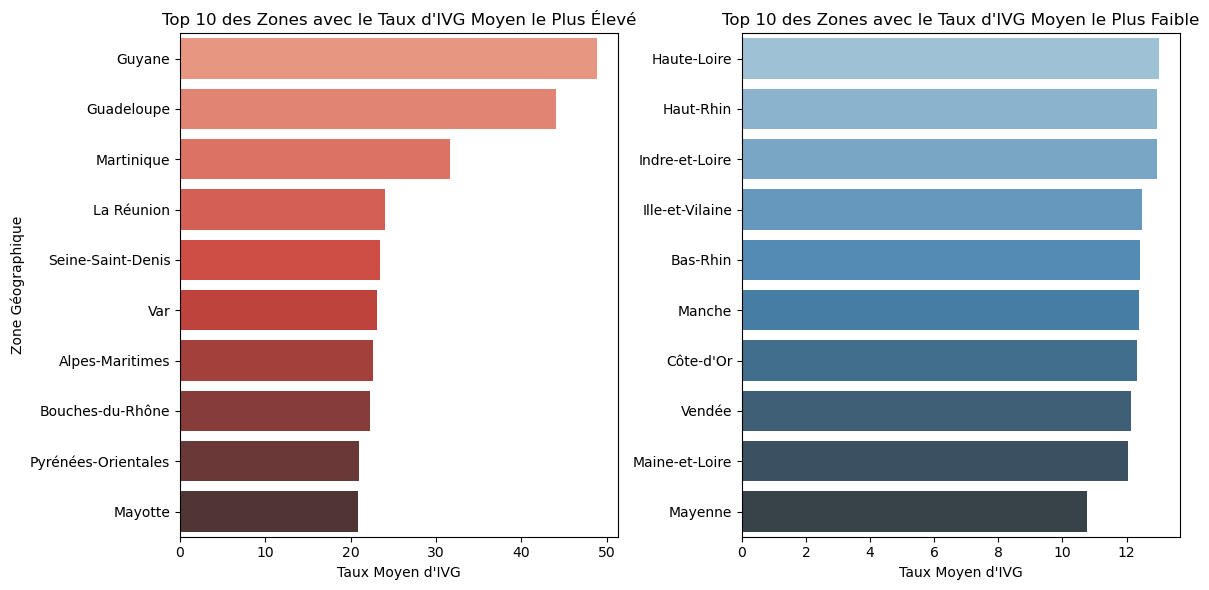

In [91]:
#Geographical Analysis of the Abortion Rate by Department

import matplotlib.pyplot as plt
import seaborn as sns

# Calculation of the average abortion rate by ZONE_GEO across all years
taux_moyen_par_zone = df_predictions_2025_dep.groupby('ZONE_GEO')['TAUX_PRED_2025'].mean().sort_values(ascending=False).reset_index()

# Top 10 areas with the highest rate
top_10 = taux_moyen_par_zone.head(10)
# Top 10 areas with the lowest rate
bottom_10 = taux_moyen_par_zone.tail(10)

plt.figure(figsize=(12, 6))

# Displaying the TOP 10
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st figure
sns.barplot(data=top_10, x='TAUX_PRED_2025', y='ZONE_GEO', palette='Reds_d')
plt.title('Top 10 des Zones avec le Taux d\'IVG Moyen le Plus Élevé', fontsize=12)
plt.xlabel('Taux Moyen d\'IVG')
plt.ylabel('Zone Géographique')

# Displaying the BOTTOM 10
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd figure
sns.barplot(data=bottom_10, x='TAUX_PRED_2025', y='ZONE_GEO', palette='Blues_d')
plt.title('Top 10 des Zones avec le Taux d\'IVG Moyen le Plus Faible', fontsize=12)
plt.xlabel('Taux Moyen d\'IVG')
plt.ylabel('') 
plt.tight_layout()
plt.show()

=== 10 départements où le modèle se trompe le plus ===


,erreur_moyenne,erreur_absolue_moyenne
ZONE_GEO,,
Alpes-Maritimes,-9.168698,9.168698
Seine-Saint-Denis,-8.763252,8.763252
Var,-8.683065,8.683065
Bouches-du-Rhône,-8.316471,8.316471
Aude,-7.938960,7.938960
Gard,-7.486645,7.486645
Val-d'Oise,-7.091978,7.091978
Pyrénées-Orientales,-6.988763,6.988763
Hautes-Alpes,-6.897826,6.897826



=== 10 départements où le modèle est le plus précis ===


,erreur_moyenne,erreur_absolue_moyenne
ZONE_GEO,,
Territoire de Belfort,-0.250777,0.250777
Creuse,0.189410,0.189410
Guadeloupe,0.173015,0.173015
Pas-de-Calais,0.172995,0.172995
Savoie,0.166765,0.166765
Gers,0.163247,0.163247
Puy-de-Dôme,-0.130056,0.130056
Aveyron,0.107715,0.107715
Loire,0.079908,0.079908


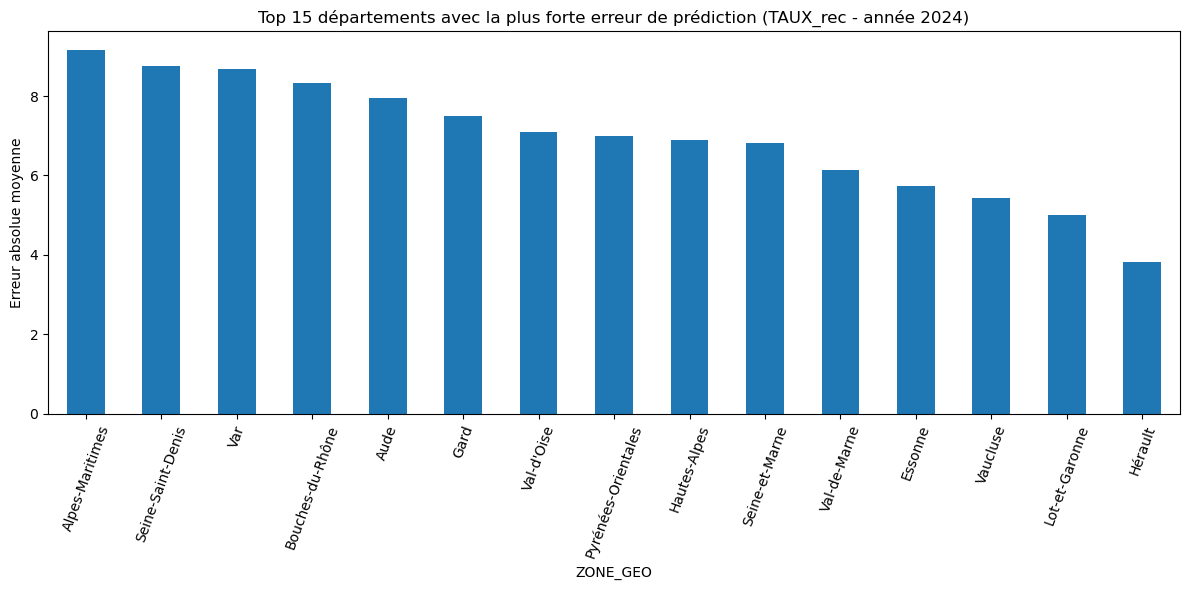

In [93]:
# ---------------------------------------
# 1. EXTRACTION DES DONNÉES 2024
# ---------------------------------------

df_2024 = df_departements[df_departements["annee"] == 2024].copy()

X_2024 = df_2024[["ZONE_GEO", "annee"]]
y_2024 = df_2024["TAUX_rec_clean"]


# ---------------------------------------
# 2. PRÉDICTIONS AVEC LE MODELE DÉJÀ ENTRAÎNÉ
# (le modèle utilisé dans vos parties précédentes : rf_reg)
# ---------------------------------------

y_pred_2024 = model_rf.predict(X_2024)

df_2024["prediction"] = y_pred_2024
df_2024["erreur"] = df_2024["prediction"] - df_2024["TAUX_rec_clean"]
df_2024["abs_erreur"] = df_2024["erreur"].abs()


# ---------------------------------------
# 3. ANALYSE PAR DÉPARTEMENT
# ---------------------------------------

df_erreurs = (
    df_2024.groupby("ZONE_GEO")[["erreur", "abs_erreur"]]
    .mean()
    .sort_values("abs_erreur", ascending=False)
    .rename(columns={
        "erreur": "erreur_moyenne",
        "abs_erreur": "erreur_absolue_moyenne"
    })
)

print("=== 10 départements où le modèle se trompe le plus ===")
display(df_erreurs.head(10))

print("\n=== 10 départements où le modèle est le plus précis ===")
display(df_erreurs.tail(10))


# ---------------------------------------
# 4. VISUALISATION DES 15 PIRES DÉPARTEMENTS
# ---------------------------------------

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df_erreurs.head(15)["erreur_absolue_moyenne"].plot(kind="bar")
plt.title("Top 15 départements avec la plus forte erreur de prédiction (TAUX_rec - année 2024)")
plt.ylabel("Erreur absolue moyenne")
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()
